# MNIST Digit Recognition with CNN

This is a very basic notebook best for new learners. Gives just an introductory idea.

Also, it shows how a very simple convolutional network can acheive great accuracy. 

## Imports

In [7]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from tempfile import TemporaryDirectory

writer = SummaryWriter('runs/mnist')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# hyperparameters
batch_size = 4

In [9]:
# data loaders

train_dataset = torchvision.datasets.MNIST(
    root='./data', download=True, train=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(
    root='./data', download=True, train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

## Preparing Dataset

In [10]:
# show all images in a batch
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(labels[i].item())
        plt.axis('off')
    plt.show()

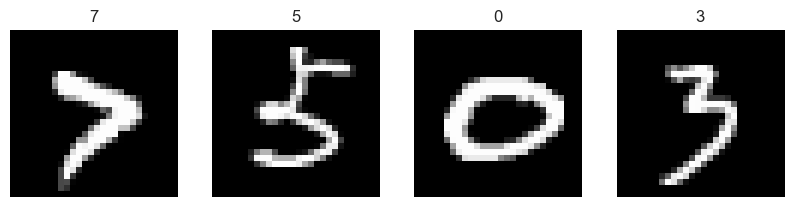

In [11]:
images, labels = next(iter(train_loader))
show_images(images, labels)

## Training a Simple Linear Model

### Defining Model

In [12]:
class LinearNet(nn.Module):
    def __init__(self, in_features=784):
        super().__init__()
        self.fc = nn.Linear(in_features, 10)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x
    
class LinearNet2(nn.Module):
    def __init__(self, in_features=784, hidden_layer=256):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_layer),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, hidden_layer),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, 10)
        )
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.fc(x)
    
# using a basic CNN architecture
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*5*5, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x
    

# better CNN architecture
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128*5*5, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [13]:
# testing different models
# 92% accuracy from a linear model
# model = LinearNet().to(device)
# lr = 1e-3

# __ accuracy from a CNN
model = ConvNet().to(device)
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [39]:
num_epochs = 4
num_batches = len(train_loader)
num_batches

15000

### Training Model

In [40]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # move images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        # backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        if (i+1) % 1000 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{num_batches}, Loss {loss:.4f}')
        

Epoch 1/4, Step 1000/15000, Loss 0.6264
Epoch 1/4, Step 2000/15000, Loss 0.0477
Epoch 1/4, Step 3000/15000, Loss 0.2411
Epoch 1/4, Step 4000/15000, Loss 0.0037
Epoch 1/4, Step 5000/15000, Loss 1.1491
Epoch 1/4, Step 6000/15000, Loss 0.1493
Epoch 1/4, Step 7000/15000, Loss 0.1052
Epoch 1/4, Step 8000/15000, Loss 0.1588
Epoch 1/4, Step 9000/15000, Loss 0.4625
Epoch 1/4, Step 10000/15000, Loss 0.0209
Epoch 1/4, Step 11000/15000, Loss 0.0257
Epoch 1/4, Step 12000/15000, Loss 0.2506
Epoch 1/4, Step 13000/15000, Loss 0.1519
Epoch 1/4, Step 14000/15000, Loss 0.5123
Epoch 1/4, Step 15000/15000, Loss 0.2170
Epoch 2/4, Step 1000/15000, Loss 0.2638
Epoch 2/4, Step 2000/15000, Loss 0.2286
Epoch 2/4, Step 3000/15000, Loss 0.0269
Epoch 2/4, Step 4000/15000, Loss 0.3800
Epoch 2/4, Step 5000/15000, Loss 0.0504
Epoch 2/4, Step 6000/15000, Loss 0.0400
Epoch 2/4, Step 7000/15000, Loss 0.0533
Epoch 2/4, Step 8000/15000, Loss 0.7452
Epoch 2/4, Step 9000/15000, Loss 0.0069
Epoch 2/4, Step 10000/15000, Loss 

In [41]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc:.2f} %')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {i}: {acc:.2f} %')

Accuracy of the network: 92.43 %
Accuracy of 0: 98.47 %
Accuracy of 1: 98.06 %
Accuracy of 2: 91.18 %
Accuracy of 3: 90.10 %
Accuracy of 4: 93.08 %
Accuracy of 5: 89.46 %
Accuracy of 6: 94.47 %
Accuracy of 7: 90.76 %
Accuracy of 8: 84.70 %
Accuracy of 9: 93.06 %


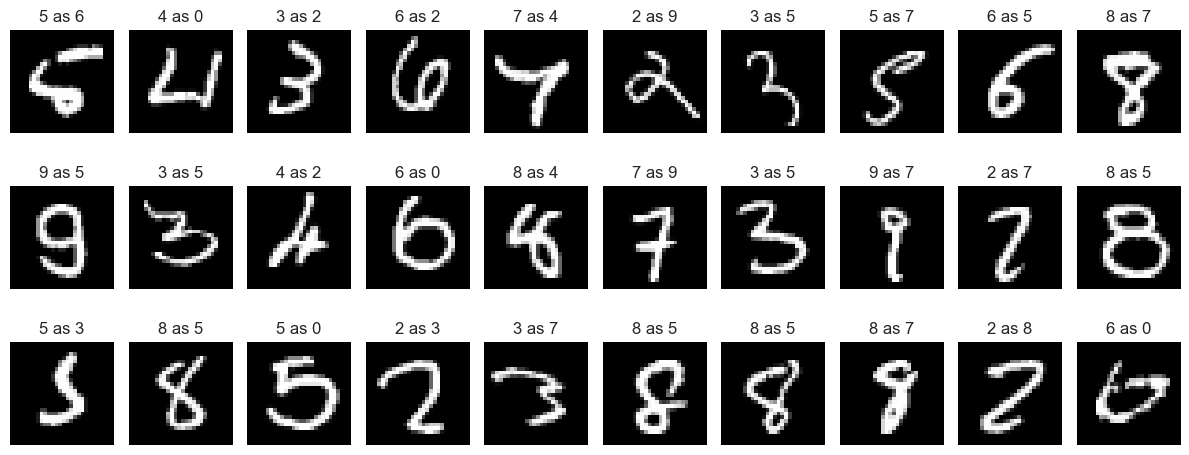

In [43]:
# visualizing incorrect predictions by the model
with torch.no_grad():
    rows = 3
    fig, axes = plt.subplots(rows, 10, figsize=(12, 5))
    axes = axes.flatten()
    ctr = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label != pred and ctr < 10*rows:
                axes[ctr].imshow(images[i, 0].cpu(), cmap='gray')
                axes[ctr].set_title(f'{label.item()} as {pred.item()}')
                axes[ctr].set_axis_off()
                ctr += 1

plt.tight_layout()

## Using Different Architectures

you can try using different CNN Architectures